In [1]:
import sys
# import os
sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
sys.path.insert(1,'/global/homes/b/bpb/repos/labkey-api-python/')
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
from metatlas.helpers import feature_tools as ft 
import multiprocessing as mp
import pandas as pd
import numpy as np

from sklearn import linear_model, datasets
from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt
from matplotlib import cm

import labkey as lk
from matplotlib import pyplot as plt
import uuid #this is because generated lists in labkey assume "name" is primary key and must be unique
%matplotlib notebook

In [2]:


def make_tasks(ref_df):
    """
    extract from what the labkey server returns metatlas formated values
    
    from the query, paths to files are returned and reference signals are returned
    
    Args:
        ref_df (pandas dataframe): the rows returned from lims system
    
    Returns:
        processing_inputs (list of dicts): 
    """
    processing_inputs = {}
    #todo: add in compound adduct, etc if its given.  currently will delete it. get an exhaustive list and do an "if in"
    #if you delete them here, they won't get written to the hdf5 file and will be lost in the process
    atlas_cols = ['label','mz','polarity','rt_max','rt_min','rt_peak']
    for ref_mix in ref_df['reference_mix'].unique():
        atlas = ref_df[ref_df['reference_mix']==ref_mix].drop_duplicates(['label','polarity'])[atlas_cols]
        files = ref_df[ref_df['reference_mix']==ref_mix].drop_duplicates(['hdf5_file','polarity'])
        processing_inputs[ref_mix] = {}
        processing_inputs[ref_mix]['atlas_pos'] = atlas[atlas['polarity']=='positive']
        processing_inputs[ref_mix]['atlas_neg'] = atlas[atlas['polarity']=='negative']          
        processing_inputs[ref_mix]['files_pos'] = files[files['polarity']=='positive']['hdf5_file'].tolist()
        processing_inputs[ref_mix]['files_neg'] = files[files['polarity']=='negative']['hdf5_file'].tolist()
    return processing_inputs



def get_control_tasks(control_type='qc'):
    """
    Query to get lcmsruns and reference signals from lims system
    
    This function gets the lcmsruns and reference signals by an 
    inner join on the reference_mix identifed for the lcmsrun run
    and the ReferenceMZRT.
    
    Args:
        control_type (str):'qc' or 'istd'
        
    Returns:
        df (pandas dataframe): this will contain the lcmsruns and reference signals to hunt for
    
    """
    
    sql = """
    SELECT run.date_finished,
    run.hdf5_file,
    run.mass_spectrometry,
    refs.mz,
    refs.rt_min,
    refs.rt_max,
    refs.rt_peak,
    refs.polarity,
    refs.label,
    refs.reference_mix
    FROM "/Project Tracking/".samples.lcmsrun_sample as run
    INNER JOIN "/Metabolite Atlas/".lists.ReferenceMZRT as refs 
    ON run.%s_reference_mix = refs.reference_mix
    AND run.liquid_chromatography=refs.liquid_chromatography
    """%control_type
    
    
    labkey_server = 'metabolomics.app.labkey.host'

#     project_name = 'Metabolite Atlas'  # Project folder name
#     m_con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)

    project_name = 'Project Tracking'  # Project folder name
    pt_con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)

    sql_result = lk.query.execute_sql(pt_con, 'lists', sql)
    if sql_result is not None:
        print("execute_sql: There are " + str(sql_result['rowCount']) + " rows.")
    else:
        print('execute_sql: Failed to load results from ' + schema + '.' + table)
    
    df = pd.DataFrame(sql_result['rows'])
    
    #TODO: This logic must be codable in the SQL query above
    pos_idx = (df['mass_spectrometry'].str.contains('_POS')) & (df['polarity']=='positive')
    neg_idx = (df['mass_spectrometry'].str.contains('_NEG')) & (df['polarity']=='negative')
    fps_idx = df['mass_spectrometry'].str.contains('_FPS')
    df = df[pos_idx|neg_idx|fps_idx]

    return df


def get_reference_mzrt(reference_type='EMA_HILICz-v11'):
    """
    Query to get reference signals from lims system
    
    Args:
        reference_mix (str):'EMA_HILICz-v11', 'polar internal standards v5', or 'QCsopV3'
        
    Returns:
        df (pandas dataframe): this will contain the reference signals to hunt for
    
    """
    
    sql = """
    SELECT refs.inchi_key,
    refs.mz,
    refs.rt_min,
    refs.rt_max,
    refs.rt_peak,
    refs.polarity,
    refs.adduct,
    refs.label,
    refs.reference_rt_space,
    refs.liquid_chromatography,
    refs.mass_spectrometry,
    refs.reference_mix
    FROM "/Metabolite Atlas/".lists.ReferenceMZRT as refs
    WHERE refs.reference_mix = '%s'
    """%reference_type
    
    labkey_server = 'metabolomics.app.labkey.host'

    project_name = 'Project Tracking'  # Project folder name
    pt_con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)

    sql_result = lk.query.execute_sql(pt_con, 'lists', sql)
    if sql_result is not None:
        print("execute_sql: There are " + str(sql_result['rowCount']) + " rows.")
    else:
        print('execute_sql: Failed to load results from ' + schema + '.' + table)
    
    df = pd.DataFrame(sql_result['rows'])
    
#     #TODO: This logic must be codable in the SQL query above
#     pos_idx = (df['mass_spectrometry'].str.contains('_POS')) & (df['polarity']=='positive')
#     neg_idx = (df['mass_spectrometry'].str.contains('_NEG')) & (df['polarity']=='negative')
#     fps_idx = df['mass_spectrometry'].str.contains('_FPS')
#     df = df[pos_idx|neg_idx|fps_idx]

    return df

def get_lcmsruns(filename='%'):
    """
    Query to get reference signals from lims system
    
    Args:
        filename (str): lcmsruns will be filtered where name contains string. 
        Use wildcards '%string%'.  Use '%' for unfiltered.
        
    Returns:
        df (pandas dataframe): this will contain the reference signals to hunt for
    
    """
    
    sql = """
    SELECT run.date_finished,
    run.hdf5_file,
    run.mass_spectrometry,
    run.name,
    run.coefficient,
    run.intercept,
    run.mean_squared_error
    --run.reference_rt_space
    FROM "/Project Tracking/".samples.lcmsrun_sample as run
    WHERE run.name LIKE '%s'
    """%filename
    
#     TODO TODO TODO
    #     TODO TODO TODO
#  ONCE EXPERIMENTS ARE STORED, LOOKUP AND GRAB THE EXPERIMENT NAME.  CURRENTLY, EXTRAT FROM HDF5 PATH!!!!!!!!
#     TODO TODO TODO
#     TODO TODO TODO
#     TODO TODO TODO
    
    labkey_server = 'metabolomics.app.labkey.host'

    project_name = 'Project Tracking'  # Project folder name
    pt_con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)

    sql_result = lk.query.execute_sql(pt_con, 'lists', sql)
    if sql_result is not None:
        print("execute_sql: There are " + str(sql_result['rowCount']) + " rows.")
    else:
        print('execute_sql: Failed to load results from ' + schema + '.' + table)
    
    df = pd.DataFrame(sql_result['rows'])
    df['date_finished'] = pd.to_datetime(df['date_finished'])
    
    df['experiment'] = df['hdf5_file'].apply(lambda x: x.split('/')[-2] if x is not None else x)
#     #TODO: This logic must be codable in the SQL query above
#     pos_idx = (df['mass_spectrometry'].str.contains('_POS')) & (df['polarity']=='positive')
#     neg_idx = (df['mass_spectrometry'].str.contains('_NEG')) & (df['polarity']=='negative')
#     fps_idx = df['mass_spectrometry'].str.contains('_FPS')
#     df = df[pos_idx|neg_idx|fps_idx]

    return df



In [ ]:
labkey_server = 'metabolomics.app.labkey.host'

project_name = 'Metabolite Atlas'  # Project folder name
pt_con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)

sql_result = lk.query.execute_sql(, 'lists', sql)
if sql_result is not None:
    print("execute_sql: There are " + str(sql_result['rowCount']) + " rows.")
else:
    print('execute_sql: Failed to load results from ' + schema + '.' + table)

df = pd.DataFrame(sql_result['rows'])

In [3]:
df = get_control_tasks(control_type='qc')
df.head()

ServerContextError: "'500: Error on line 11: Query or table not found: /Project Tracking/.samples.lcmsrun_sample'"

In [4]:
def setup_dataframe(input_data,min_intensity=1e5,use_data=False):
    """
    
    """
    if use_data==True:
        df = input_data['ms1_summary'].copy()
        df.set_index('label',drop=True,inplace=True)
    else:
        df = pd.read_hdf(input_data['outfile'],'ms1_summary').set_index('label',drop=True)
    
    if use_data==True:
        atlas = input_data['atlas'].copy()
        atlas.set_index('label',drop=True,inplace=True)
    else:
        atlas = pd.read_hdf(input_data['outfile'],'atlas').set_index('label',drop=True)
    df = pd.merge(df,atlas,how='outer',left_index=True,right_index=True,suffixes=['_measured','_atlas'])
    
    # replace nan with zero for hits with no signal
    df.loc[pd.isna(df['num_datapoints']),['num_datapoints','peak_height','peak_area']] = 0
    
    if use_data==True:
        eic = input_data['ms1_data']
    else:
        eic = pd.read_hdf(input_data['outfile'],'ms1_data')
    eic = eic[eic['i']>min_intensity]
    eic = ft.group_duplicates(eic[['label','rt','mz','i','in_feature']],'label',make_string=False).set_index('label',drop=True)
    eic.columns = ['eic_%s'%c for c in eic.columns]
    df = pd.merge(df,eic,how='outer',left_index=True,right_index=True)
    
    if use_data==True:
        msms = input_data['ms2_data']
    else:
        msms = pd.read_hdf(input_data['outfile'],'ms2_data')
    msms = msms[msms['i']>min_intensity]
    msms = ft.group_duplicates(msms[['label','mz','i','rt','in_feature']],'label',make_string=False).set_index('label',drop=True)
    msms.columns = ['msms_%s'%c for c in msms.columns]
    df = pd.merge(df,msms,left_index=True,right_index=True,how='left')
    
    return df


In [5]:
ft = reload(ft)
for control_type in ['qc','istd']:
    df = get_control_tasks(control_type=control_type)
    processing_inputs = make_tasks(df)

    for polarity in ['positive','negative']:

        polarity_short = polarity[:3] #pos/neg is nomenclature in the hdf5 files

        # define the name of the reference mix you are using
        for reference_mix in processing_inputs.keys(): # 'polar internal standards v5' is typically the only one
            print('working on %s %s'%(polarity,reference_mix))
            atlas = processing_inputs[reference_mix]['atlas_%s'%polarity_short]
#             atlas.reset_index(inplace=True)
            filenames = processing_inputs[reference_mix]['files_%s'%polarity_short]           
            input_data = ft.setup_file_slicing_parameters(atlas,filenames,polarity=polarity,project_dir=False)

            print('getting data')
            print('making eics and msms.')
            all_dfs = []
            for f in input_data:
                data = ft.get_data(f,return_data=True,save_file=False)
                df = setup_dataframe(data,use_data=True)
                #TODO!!!! THIS MUST BE PRESERVED AS THE NAME FIELD (PK) FOR LCMSRUN_SAMPLES !!!!!!!
                df['lcmsrun'] = '%s.mzML'%os.path.basename(f['lcmsrun'].split('.')[0])
                df['hdf5_file'] = f['lcmsrun']
                df['feature_file'] = f['outfile']
                df['polarity'] = f['polarity']
                df['reference_mix'] = reference_mix
                df.reset_index(inplace=True)
                #basic cleanup
                df.loc[pd.isna(df['num_datapoints']),'num_datapoints'] = 0
                #TODO: Decide what to do about uuids
                df['name'] = [str(uuid.uuid4()) for i in range(df.shape[0])]

                #string arrays to fixed precision
                print('stringifying ndarrays')
                str_df = df.copy()
                d = df.to_dict('records')
                for k,v in d[0].items():
                    if any('ndarray' in str(type(dd[k])) for dd in d):
                        # convert np.array to string if nan==float then None
                        # convert np.array to string if nan==float then None
                        if 'mz' in k:
                            p=5 #gets you better than 1 ppm
                        elif 'rt' in k:
                            p=3 #60 milliseconds
                        else:
                            p=1 #intensity becomes low precision


                        if 'in_feature' in k:
                            t = 'bool'
                        else:
                            t = 'float'
                        np.set_printoptions(suppress=True,formatter={'float_kind':('{:0.%df}'%p).format},threshold=1e6) 
                        str_df[k] = str_df[k].apply(lambda x: np.array2string(x.astype(t),precision=p,floatmode='fixed',separator=',',max_line_width=1e10) if type(x)!=float else None)
                    
                #send to lims
                print('sending to lims system')
                labkey_server = 'metabolomics.app.labkey.host'
                project_name = 'Project Tracking'  # Project folder name
                pt_con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)        
                insertResult = lk.query.insert_rows(pt_con, 'lists', '%s_signals'%control_type, str_df.to_dict('records'))
                print('done\n')


#             print('exporting csv')
#             df.to_csv('/global/homes/b/bpb/Downloads/%s_signals_%s_%s.csv'%(control_type,reference_mix,polarity_short),index=None)
            
    

    
# ft = reload(ft)
# d = ft.get_data(input_data[1],return_data=True,save_file=False)

# ms1_summary = d['ms1_summary']

# df = setup_dataframe(input_data[0],reference_mix)
# df.head()

execute_sql: There are 6072 rows.
working on positive QCsopV3
getting data
making eics and msms.
stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lim

done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sen

done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sen

done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sen

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending t

done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sending to lims system
done

stringifying ndarrays
sen

In [ ]:
# ft = reload(ft)
# for control_type in ['qc','istd']:
#     df = get_control_tasks(control_type=control_type)
#     processing_inputs = make_tasks(df)

#     for polarity in ['positive','negative']:

#         polarity_short = polarity[:3] #pos/neg is nomenclature in the hdf5 files

#         # define the name of the reference mix you are using
#         for reference_mix in processing_inputs.keys(): # 'polar internal standards v5' is typically the only one
#             print('working on %s %s'%(polarity,reference_mix))
#             atlas = processing_inputs[reference_mix]['atlas_%s'%polarity_short]
#             atlas.reset_index(inplace=True)
#             filenames = processing_inputs[reference_mix]['files_%s'%polarity_short]
            
#             input_data = ft.setup_file_slicing_parameters(atlas,filenames,polarity=polarity,project_dir='test_labkey')

#             print('getting data')
# #             pool = mp.Pool(processes=8)
# #             data = pool.map(ft.get_data,input_data)
# #             pool.close()
# #             pool.join()
            
#             print('making eics and msms.')
#             all_dfs = []
#             for f in input_data:
#                 data = ft.get_data(f,return_data=False,save_file=True)
#                 df = setup_dataframe(f,use_data=False)
#                     #TODO!!!! THIS MUST BE PRESERVED AS THE NAME FIELD (PK) FOR LCMSRUN_SAMPLES !!!!!!!
#                 df['lcmsrun'] = '%s.mzML'%os.path.basename(f['lcmsrun'].split('.')[0])
#                 df['hdf5_file'] = f['lcmsrun']
#                 df['feature_file'] = f['outfile']
#                 df['polarity'] = f['polarity']
#                 df['reference_mix'] = reference_mix
#                 all_dfs.append(df)
#             df = pd.concat(all_dfs)
#             df.reset_index(inplace=True)
            
#             #basic cleanup
#             df.loc[pd.isna(df['num_datapoints']),'num_datapoints'] = 0

#             df['name'] = [str(uuid.uuid4()) for i in range(df.shape[0])]

#             #string arrays to fixed precision
#             print('stringifying ndarrays')
#             str_df = df.copy()
#             d = df.to_dict('records')
#             for k,v in d[0].items():
#                 if any('ndarray' in str(type(dd[k])) for dd in d):
#                     # convert np.array to string if nan==float then None
#                     # convert np.array to string if nan==float then None
#                     if 'mz' in k:
#                         p=5 #gets you better than 1 ppm
#                     elif 'rt' in k:
#                         p=3 #60 milliseconds
#                     else:
#                         p=1 #intensity becomes low precision
                        

#                     if 'in_feature' in k:
#                         t = 'bool'
#                     else:
#                         t = 'float'
#                     np.set_printoptions(suppress=True,formatter={'float_kind':('{:0.%df}'%p).format},threshold=1e6) 
#                     str_df[k] = str_df[k].apply(lambda x: np.array2string(x.astype(t),precision=p,floatmode='fixed',separator=',',max_line_width=1e10) if type(x)!=float else None)
            
#             print('exporting csv')
#             df.to_csv('/global/homes/b/bpb/Downloads/%s_signals_%s_%s.csv'%(control_type,reference_mix,polarity_short),index=None)
            
#             print('sending to lims system')
#             labkey_server = 'metabolomics.app.labkey.host'
#             project_name = 'Project Tracking'  # Project folder name
#             pt_con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)        
#             insertResult = lk.query.insert_rows(pt_con, 'lists', '%s_signals'%control_type, str_df.to_dict('records'))
#             print('done')
    

    
# # ft = reload(ft)
# # d = ft.get_data(input_data[1],return_data=True,save_file=False)

# # ms1_summary = d['ms1_summary']

# # df = setup_dataframe(input_data[0],reference_mix)
# # df.head()

In [6]:
def get_reference_signals(control_type='qc'):
    """
    Query to get lcmsruns and reference signals from lims system
    
    This function gets the lcmsruns and reference signals by an 
    inner join on the reference_mix identifed for the lcmsrun run
    and the ReferenceMZRT.
    
    Args:
        control_type (str):'qc' or 'istd'
        
    Returns:
        df (pandas dataframe): this will contain the lcmsruns and reference signals to hunt for
    
    """
    
    sql = """
    SELECT refs.peak_height,
    refs.rt_peak_measured,
    refs.rt_peak_atlas,
    refs.mz_centroid,
    refs.mz,
    refs.hdf5_file,
    refs.lcmsrun,
    refs.polarity,
    refs.label,
    refs.reference_mix
    FROM "/Project Tracking/".lists.%s_signals as refs
    """%control_type
    
    
    labkey_server = 'metabolomics.app.labkey.host'

#     project_name = 'Metabolite Atlas'  # Project folder name
#     m_con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)

    project_name = 'Project Tracking'  # Project folder name
    pt_con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)

    sql_result = lk.query.execute_sql(pt_con, 'lists', sql)
    if sql_result is not None:
        print("execute_sql: There are " + str(sql_result['rowCount']) + " rows.")
    else:
        print('execute_sql: Failed to load results from ' + schema + '.' + table)
    
    df = pd.DataFrame(sql_result['rows'])
    

    return df
df = get_reference_signals(control_type='qc')
df.head()

execute_sql: There are 5676 rows.


,_labkeyurl_lcmsrun,_labkeyurl_reference_mix,hdf5_file,label,lcmsrun,mz,mz_centroid,peak_height,polarity,reference_mix,rt_peak_atlas,rt_peak_measured
0,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/project/projectdirs/metatlas/raw_data/akuftin...,carnitine; [M]+,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,161.105193,NaN,0.0,positive,QCsopV3,13.285827,NaN
1,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/project/projectdirs/metatlas/raw_data/jsjorda...,acetylcholine; [M-2H]-,20190118_JJ_KZ_Switchgrass_Greenhouse_Bulk1017...,144.103002,NaN,0.0,negative,QCsopV3,1.955286,NaN
2,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/project/projectdirs/metatlas/raw_data/akuftin...,lactic acid; [M+H]+,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,91.038994,NaN,0.0,positive,QCsopV3,5.064399,NaN
3,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/project/projectdirs/metatlas/raw_data/jsjorda...,carnitine; [M-2H]-,20190111_JJ_KZ_Switchgrass_Greenhouse_Bulk1017...,159.090640,NaN,0.0,negative,QCsopV3,13.285827,NaN
4,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/project/projectdirs/metatlas/raw_data/akuftin...,mannitol; [M+H]+,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,183.086338,NaN,0.0,positive,QCsopV3,9.534507,NaN


# store slope and intercept for all QC files

In [89]:
e = str(e)
e.strip()

'Failed to solve the system of normal equations'

In [94]:
# fig,ax = plt.subplots(nrows=6,ncols=8,figsize=(14,8))
# ax = ax.flatten()

print('getting reference signals')
df = get_reference_signals(control_type='qc')

print('sending to lims system')
labkey_server = 'metabolomics.app.labkey.host'
project_name = 'Project Tracking'  # Project folder name
pt_con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)        
# insertResult = lk.query.insert_rows(pt_con, 'lists', '%s_signals'%control_type, str_df.to_dict('records'))

for i,f in enumerate(df.lcmsrun.unique()):
    small_df = df[df.lcmsrun==f]
    small_df = small_df[small_df['rt_peak_measured']!='NaN']
    small_df = small_df[small_df['peak_height']>1e5]
    small_df.reset_index(drop=True,inplace=True)
    x = small_df.rt_peak_atlas.values.reshape(-1, 1)
    y = small_df.rt_peak_measured.values#.flatten().reshape(-1, 1)
    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    mse = 1e9
    # do the fit 10 times just in case it fails a few times.  Keep the best one.
    for i in range(10):
        try: #The ransac code failes about 1 in 100 times.
            ransac.fit(x, y)
            y_pred = ransac.predict(x)
            temp_mse = np.mean((y_pred-y)**2)
            if temp_mse < mse:
                m = ransac.estimator_.coef_[0]
                b = ransac.estimator_.intercept_
                mse = temp_mse
        except SystemError as e:
            e = str(e)
            e = e.strip()
            if e != "Failed to solve the system of normal equations":
                raise
            else:
                print("caught!")

        
#     ax[i].plot(x,y,'.')
#     ax[i].plot(line_X,line_y_ransac,'k-')
    new_data = {'Name':f,'coefficient':m,'intercept':b,'mean_squared_error':mse, 'reference_rt_space':small_df.loc[0,'reference_mix']}
    insertResult = lk.query.update_rows(pt_con, 'samples', 'lcmsrun_sample', [new_data])
    
    print(small_df.shape,new_data['coefficient'],new_data['intercept'],new_data['mean_squared_error'])

    
# plt.tight_layout()    

getting reference signals
execute_sql: There are 5676 rows.
sending to lims system
((115, 12), 0.9929835305567092, -0.10319432197409902, 0.04313524296693261)
((113, 12), 0.9840986862491437, -0.16357551510622065, 0.07025551686476593)
((24, 12), 0.991278202099076, -0.08520439291736905, 0.20871262197291104)
((114, 12), 0.9854974040369027, -0.1416802946523614, 0.06360357668997346)
((115, 12), 0.9926450662603816, -0.10687420085351955, 0.044509366682111424)
((113, 12), 0.983703135970729, -0.16040794036122344, 0.07062228279830492)
((52, 12), 0.9827220809929433, -0.052040965583915105, 0.057285087615479444)
((113, 12), 0.9825417287617547, -0.11836952555488985, 0.0666503099036059)
((115, 12), 0.9926166720187832, -0.12674384673717995, 0.04559639636386499)
((114, 12), 0.9842565869047881, -0.13705630413815398, 0.06807205944420963)
((116, 12), 0.985640958006002, -0.14164113266095468, 0.07002012096012725)
((111, 12), 0.9834414058072672, -0.15628992750333046, 0.07165467080026702)
((112, 12), 0.9836657

# now fit the internal standards

In [112]:
# fig,ax = plt.subplots(nrows=6,ncols=8,figsize=(14,8))
# ax = ax.flatten()

print('getting reference signals')
df = get_reference_signals(control_type='istd')

print('sending to lims system')
labkey_server = 'metabolomics.app.labkey.host'
project_name = 'Project Tracking'  # Project folder name
pt_con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)        
# insertResult = lk.query.insert_rows(pt_con, 'lists', '%s_signals'%control_type, str_df.to_dict('records'))

for i,f in enumerate(df.lcmsrun.unique()):
    small_df = df[df.lcmsrun==f]
    small_df = small_df[small_df['rt_peak_measured']!='NaN']
    small_df = small_df[small_df['peak_height']>1e5]
    small_df.reset_index(drop=True,inplace=True)
    if small_df.shape[0] > 15:
        x = small_df.rt_peak_atlas.values.reshape(-1, 1)
        y = small_df.rt_peak_measured.values#.flatten().reshape(-1, 1)
        # Robustly fit linear model with RANSAC algorithm
        ransac = linear_model.RANSACRegressor()
        mse = 1e9
        # do the fit 10 times just in case it fails a few times.  Keep the best one.
        for i in range(10):
            try: #The ransac code failes about 1 in 100 times.
                ransac.fit(x, y)
                y_pred = ransac.predict(x)
                temp_mse = np.mean((y_pred-y)**2)
                if temp_mse < mse:
                    m = ransac.estimator_.coef_[0]
                    b = ransac.estimator_.intercept_
                    mse = temp_mse
            except SystemError as e:
                e = str(e)
                e = e.strip()
                if e != "Failed to solve the system of normal equations":
                    raise
                else:
                    print("caught!")


    #     ax[i].plot(x,y,'.')
    #     ax[i].plot(line_X,line_y_ransac,'k-')
        new_data = {'Name':f,'coefficient':m,'intercept':b,'mean_squared_error':mse, 'reference_rt_space':small_df.loc[0,'reference_mix']}
        insertResult = lk.query.update_rows(pt_con, 'samples', 'lcmsrun_sample', [new_data])

        print(small_df.shape,new_data['coefficient'],new_data['intercept'],new_data['mean_squared_error'])

    
# plt.tight_layout()    

getting reference signals
execute_sql: There are 16700 rows.
sending to lims system
((19, 12), 1.040196887405894, -0.3628017131950605, 0.04248579094757212)
((19, 12), 1.0420784847726527, -0.39372510720719184, 0.04356235233517654)
((19, 12), 1.0374691225627333, -0.3386692124337563, 0.03174963210487027)
((18, 12), 1.036868359833159, -0.32647357474578115, 0.030149208139303402)
((19, 12), 1.0370860752929187, -0.3306029116409646, 0.028968969148121554)
caught!
((19, 12), 1.036099514253081, -0.3211718613415421, 0.02795907539907442)
((19, 12), 1.0377443284770582, -0.33685993948487447, 0.03524712907096617)
((19, 12), 1.035391742984363, -0.3077176464716549, 0.035267740120121106)
((19, 12), 1.0376146689806167, -0.3631326614003099, 0.018050991302093297)
((18, 12), 1.0436436586451248, -0.4176134176193413, 0.04232958598840843)
((19, 12), 1.0379481755734445, -0.3437389698770318, 0.029279738865981206)
((19, 12), 1.0373151729574435, -0.33737703036738687, 0.0321919162585479)
((19, 12), 1.036900576891527

((20, 12), 1.0340800905323217, -0.30231550943574975, 0.027328432283018088)
((20, 12), 1.0081166262368866, -0.039764691575169396, 0.06852188403563415)
((40, 12), 1.0346374611986875, -0.300684283248628, 0.029122614587446645)
((20, 12), 1.0327875149373866, -0.2740949489937604, 0.027042712589263045)
((20, 12), 1.0349199152063715, -0.30636645982616806, 0.028068042281999855)
((20, 12), 1.0362273136623343, -0.3205156888553798, 0.03649829112750164)
((20, 12), 1.0347531290744465, -0.3117344655823973, 0.027157222305751738)
((20, 12), 1.0393022314019982, -0.36892215973149983, 0.03650064057394703)
((20, 12), 1.0346570012918246, -0.31164657257982975, 0.02782672510820326)
((20, 12), 1.036130830814212, -0.3310187633319542, 0.027123201942189645)
((20, 12), 1.0334678914003654, -0.2869033807711523, 0.026896762551306706)
((40, 12), 1.0355809434555185, -0.31099845415323735, 0.03136274192383926)
((20, 12), 1.0360340800753012, -0.3282272045622272, 0.02769047409212034)
caught!
((20, 12), 1.03356296167087, -0

((40, 12), 1.0374762390459977, -0.3470472497787744, 0.03233438237713862)
caught!
((40, 12), 1.0357849711853075, -0.3068595682482034, 0.03367979455726912)
((20, 12), 1.034810815340155, -0.303721062306297, 0.030028415138195368)
((20, 12), 1.0372858805159986, -0.3466026269144323, 0.030893285337979463)
((20, 12), 1.0371665870168258, -0.34430202627242806, 0.02967089573809186)
((40, 12), 1.0381547109875098, -0.34685752438330136, 0.036355912556502744)
((20, 12), 1.0352219012993915, -0.3093233545829345, 0.031777947093210954)
((20, 12), 1.0341354718747133, -0.29642301944736454, 0.030805849430740117)
((20, 12), 1.0378568784985585, -0.3610406218896749, 0.03045792689344451)
((20, 12), 1.0353675076719724, -0.31562040031283867, 0.03091849210944685)
((20, 12), 1.0392019988200834, -0.3752532362670539, 0.032059804639402584)
((20, 12), 1.0352703560148528, -0.3008074548472578, 0.03453065310531192)
((20, 12), 1.038078500288486, -0.3466677136812504, 0.03528617003380414)
((20, 12), 1.0359894782596006, -0.32

In [21]:
# myArr[myArr > myNumber].min()
# myArr[myArr < myNumber].max()
def nearest_ind(items, pivot):
    indices = []
    earlier_indices = items[items>pivot] #find earlier reference
    later_indices = items[items<pivot]  #find later reference
    if len(earlier_indices)>0:
        indices.append(earlier_indices.idxmin())
    if len(later_indices)>0:
        indices.append(later_indices.idxmax())
    return indices


df = get_lcmsruns()
df['coefficient'] = pd.to_numeric(df['coefficient'])
no_coef = df[pd.isnull(df['coefficient'])]
coef = df[~pd.isnull(df['coefficient'])]
coef.reset_index(inplace=True,drop=True)
no_coef.reset_index(inplace=True,drop=True)
for i,row in no_coef.head().iterrows():
    idx = nearest_ind(coef.loc[coef['experiment']==row['experiment'],'date_finished'],row['date_finished'])
#     print(row['name'],len(idx))
#     print(i,len(idx),row['date_finished'],np.mean([float(coef.loc[i,'intercept']) for i in idx]),)
    new_data = {'name':row['name'],
                'coefficient':np.mean([float(coef.loc[i,'coefficient']) for i in idx]),
                'intercept': np.mean([float(coef.loc[i,'intercept']) for i in idx]),
                'reference_rt_space':'QCsopV3'}
    print(idx,new_data)
#     insertResult = lk.query.update_rows(pt_con, 'samples', 'lcmsrun_sample', [new_data])
    

execute_sql: There are 1140 rows.
([0], {'coefficient': 0.9926166534423828, 'intercept': -0.1267438530921936, 'name': u'20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HILIC_USHGX01163_FPS_MS1_0_InjBL-MeOH_Post_Rg70to1050---InjBL-MeOH_Run423.mzML', 'reference_rt_space': 'QCsopV3'})
([0], {'coefficient': 0.9926166534423828, 'intercept': -0.1267438530921936, 'name': u'20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HILIC_USHGX01163_FPS_MS1_0_InjBL-MeOH_Post_Rg70to1050---InjBL-MeOH_Run424.mzML', 'reference_rt_space': 'QCsopV3'})
([0], {'coefficient': 0.9926166534423828, 'intercept': -0.1267438530921936, 'name': u'20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HILIC_USHGX01163_FPS_MS1_0_InjBL-MeOH_Post_Rg70to1050---InjBL-MeOH_Run425.mzML', 'reference_rt_space': 'QCsopV3'})
([1], {'coefficient': 0.9929835200309752, 'intercept': -0.10319431871175766, 'name': u'20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HILIC_USHGX01163_FPS_MS1_0_InjBL-MeOH_Pre_Rg70to1050---InjBL-MeOH_Run1.mzML', 'reference_rt_space': 'QCs

In [113]:
df = get_lcmsruns()
# idx = (df['name'].str.contains('_JP_')) & (df['name'].str.contains('_QC_'))
# print(sum(idx))
# plt.close('all')
# fig,ax =plt.subplots()
# x = np.asarray(df[idx].date_finished)
# y = np.asarray(df[idx].intercept.apply(lambda x: float(x)))
# c = np.asarray(df[idx].mean_squared_error.apply(lambda x: float(x)))
# avg = np.sum(y/c)/np.sum(1/c)
# ax.plot(x,y,'.')
# ax.axhline(avg)
# plt.show()

execute_sql: There are 1140 rows.


In [118]:
df[idx]

,RowId,_labkeyurl_RowId,_labkeyurl_mass_spectrometry,_labkeyurl_name,coefficient,date_finished,hdf5_file,intercept,mass_spectrometry,mean_squared_error,name,experiment
0,31956,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/Project%20Tracking/experiment-showMaterial.vi...,None,2019-01-10 14:40:45,/project/projectdirs/metatlas/raw_data/akuftin...,None,MS1-v1_FPS,NaN,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...
1,31957,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/Project%20Tracking/experiment-showMaterial.vi...,None,2019-01-10 15:02:48,/project/projectdirs/metatlas/raw_data/akuftin...,None,MS1-v1_FPS,NaN,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...
2,31958,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/Project%20Tracking/experiment-showMaterial.vi...,None,2019-01-10 15:24:52,/project/projectdirs/metatlas/raw_data/akuftin...,None,MS1-v1_FPS,NaN,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...
3,31959,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/Project%20Tracking/experiment-showMaterial.vi...,None,2019-01-04 02:11:43,/project/projectdirs/metatlas/raw_data/akuftin...,None,MS1-v1_FPS,NaN,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...
4,31960,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/Project%20Tracking/experiment-showMaterial.vi...,None,2019-01-04 05:30:16,/project/projectdirs/metatlas/raw_data/akuftin...,None,MS1-v1_FPS,NaN,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...
5,31961,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/Project%20Tracking/experiment-showMaterial.vi...,None,2019-01-04 02:33:49,/project/projectdirs/metatlas/raw_data/akuftin...,None,MS1-v1_FPS,NaN,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...
6,31962,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/Project%20Tracking/experiment-showMaterial.vi...,None,2019-01-04 02:55:51,/project/projectdirs/metatlas/raw_data/akuftin...,None,MS1-v1_FPS,NaN,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...
7,31963,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/Project%20Tracking/experiment-showMaterial.vi...,None,2019-01-04 03:17:54,/project/projectdirs/metatlas/raw_data/akuftin...,None,MS1-v1_FPS,NaN,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...
8,31964,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/Project%20Tracking/experiment-showMaterial.vi...,None,2019-01-04 03:40:01,/project/projectdirs/metatlas/raw_data/akuftin...,None,MS1-v1_FPS,NaN,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...
9,31965,/Project%20Tracking/experiment-showMaterial.vi...,/Project%20Tracking/list-details.view?listId=6...,/Project%20Tracking/experiment-showMaterial.vi...,None,2019-01-04 04:46:10,/project/projectdirs/metatlas/raw_data/akuftin...,None,MS1-v1_FPS,NaN,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...,20190103_KBL_JP_502924_Soil_13CFlux_QE-139_HIL...


execute_sql: There are 1140 rows.
299


Traceback (most recent call last):
  File "/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/backends/backend_nbagg.py", line 241, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/_pylab_helpers.py", line 58, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


<IPython.core.display.Javascript object>


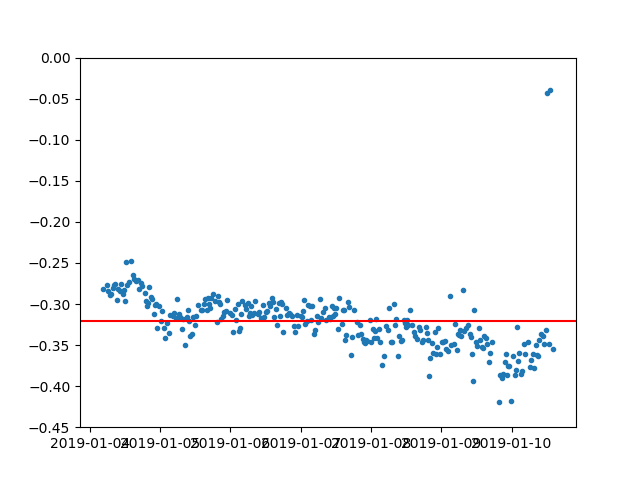

In [138]:
df = get_lcmsruns()
idx = (df['name'].str.contains('_JP_')) & (pd.to_numeric(df['coefficient'],'force')>0) &  (~df['name'].str.contains('-QC_'))
print(sum(idx))
plt.close('all')
fig,ax =plt.subplots()
x = np.asarray(df[idx].date_finished)
y = np.asarray(df[idx].intercept.apply(lambda x: float(x)))
c = np.asarray(df[idx].mean_squared_error.apply(lambda x: float(x)))
avg = np.sum(y/c)/np.sum(1/c)
ax.plot(x,y,'.')
plt.axhline(avg,color='red')
ax.set_ylim(-0.45,0)
plt.show()

execute_sql: There are 1140 rows.
31


<IPython.core.display.Javascript object>


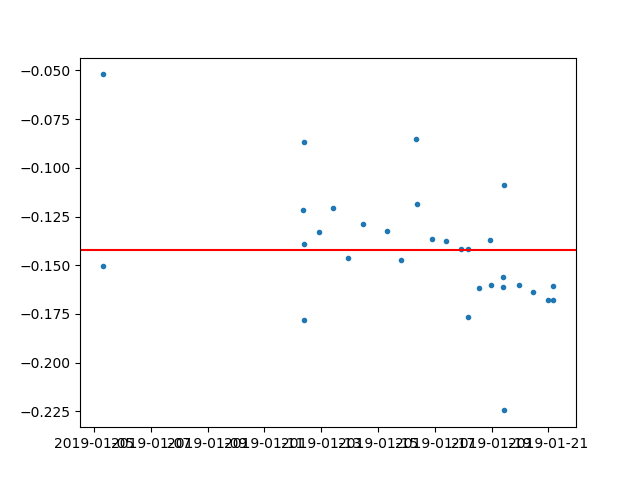

In [141]:
df = get_lcmsruns()
idx = (df['name'].str.contains('_KZ_')) & (pd.to_numeric(df['coefficient'],'force')>0) &  (~df['name'].str.contains('_QC'))
print(sum(idx))
plt.close('all')
fig,ax =plt.subplots()
x = np.asarray(df[idx].date_finished)
y = np.asarray(df[idx].intercept.apply(lambda x: float(x)))
c = np.asarray(df[idx].mean_squared_error.apply(lambda x: float(x)))
avg = np.sum(y/c)/np.sum(1/c)
ax.plot(x,y,'.')
ax.axhline(avg,color='red')
plt.show()

execute_sql: There are 1140 rows.
31


Traceback (most recent call last):
  File "/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/backends/backend_nbagg.py", line 241, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/_pylab_helpers.py", line 58, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


<IPython.core.display.Javascript object>


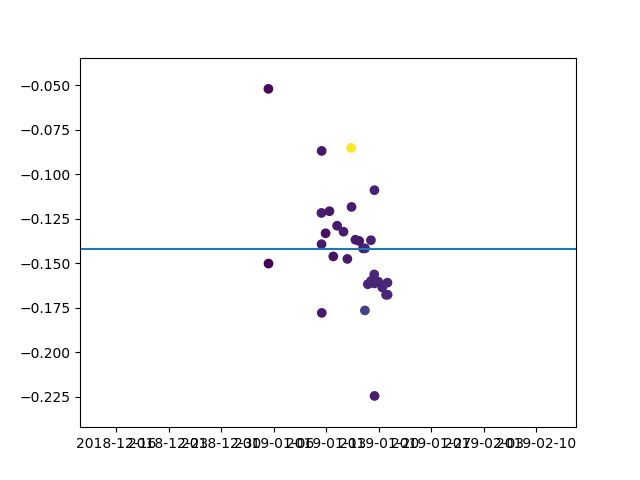

In [106]:
df = get_lcmsruns()
idx = (df['name'].str.contains('_KZ_')) & (df['name'].str.contains('_QC'))
print(sum(idx))
# fig,ax =plt.subplots()
x = np.asarray(df[idx].date_finished)
y = np.asarray(df[idx].intercept.apply(lambda x: float(x)))
c = np.asarray(df[idx].mean_squared_error.apply(lambda x: float(x)))
avg = np.sum(y/c)/np.sum(1/c)

plt.close('all')
plt.scatter(x,y,c=c)
plt.axhline(avg)
plt.show()

In [ ]:
idx = df['name'].str.contains('_KZ_')
plt.plot(df[idx].date_finished,df[idx].intercept.apply(lambda x: float(x)),'.')

# create an experimental atlas

In [ ]:
df = get_reference_mzrt()
df.head()

In [ ]:
# df = get_lcmsruns(filename='%POS%')
df = get_lcmsruns()

df.head()

In [ ]:
# For each QC file, get the slope and intercept


In [22]:
plt.ioff()
colors = ['red','black']
for i,f in enumerate(df.hdf5_file.unique()):
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))

    small_df = df[df.hdf5_file==f]
    small_df = small_df[small_df['mz_centroid']!='NaN']
    small_df = small_df[small_df['peak_height']>1e6]
    if len(small_df.polarity.unique())>1:
        for j,p in enumerate(['positive','negative']):
            
            x = small_df[small_df['polarity']==p].mz.values
            y = small_df[small_df['polarity']==p].mz_centroid.values
            temp = np.divide(x-y,x)*1e6
            bins = np.linspace(-20,20,41)
            ax.hist(np.reshape(temp,(len(temp),1)),bins=bins,color=colors[j],alpha=0.6)
            ax.set_title(os.path.basename(f))
    else:
        x = small_df[small_df['polarity']==p].mz.values
        y = small_df[small_df['polarity']==p].mz_centroid.values
        temp = np.divide(x-y,x)*1e6
        bins = np.linspace(-20,20,41)
        ax.hist(np.reshape(temp,(len(temp),1)),bins=bins,color='blue',alpha=1)
    fig.savefig('/global/homes/b/bpb/Downloads/qcfigs/%s.pdf'%(os.path.basename(f).split('.')[0]))
    plt.close('all')
plt.ion()

KeyError: 'mz_centroid'

In [23]:
atlas = processing_inputs['QCsopV3']['atlas_pos']
filenames = processing_inputs['QCsopV3']['files_pos']
input_data = setup_file_slicing(atlas,filenames)

ft = reload(ft)
d = ft.get_data(input_data[1],return_data=True,save_file=False)

ms1_summary = d['ms1_summary']
measured_signals = ms1_summary[ms1_summary['peak_height']>1e6].sort_values('label')
df = pd.merge(measured_signals,processing_inputs['QCsopV3']['atlas_pos'][['label','rt_peak']],left_on='label',right_on='label',how='left',suffixes=['_measured','_theoretical'])

x = df['rt_peak_theoretical'].values.reshape(-1, 1)
y = df['rt_peak_measured'].values

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(x, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(x, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(x.min(), x.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# fit using a Huber Regressor
epsilon_values = [1.35, 1.5, 1.75, 1.9]
for k, epsilon in enumerate(epsilon_values):
    huber = HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100,
                       epsilon=epsilon)
    huber.fit(x, y)
    print('Huber',huber.coef_,huber.intercept_)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(lr.coef_, ransac.estimator_.coef_)
print(lr.intercept_,ransac.estimator_.intercept_,)

lw = 2
plt.scatter(x[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(x[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Theoretical")
plt.ylabel("Measured")
plt.show()

KeyError: 'QCsopV3'

In [ ]:


# filters = [
#     lk.query.QueryFilter('inchi_key', 'RWQNBRDOKXIBIV-UHFFFAOYSA-N'),
#     lk.query.QueryFilter('precursor_mz', '125, 125.5', lk.query.QueryFilter.Types.BETWEEN),
#     lk.query.QueryFilter('database','mo',lk.query.QueryFilter.Types.CONTAINS)
#     ]

# schema = 'lists'
# table = 'ReferenceMSMS'
# result = lk.query.select_rows(con, schema, table, filter_array=filters)

# if result is not None:
#     print("select_rows: There are " + str(result['rowCount']) + " rows.")
#     df = pd.DataFrame(result['rows'])
# else:
#     print('select_rows: Failed to load results from ' + schema + '.' + table)
# df

In [ ]:
###################
# Test execute_sql
###################
sql = """SELECT 
msms.collision_energy,
  cpd.name
FROM ReferenceMSMS AS msms
INNER JOIN MetAtlasCompounds AS cpd ON msms.inchi_key  = cpd.inchi_key
WHERE msms.inchi_key ='RWQNBRDOKXIBIV-UHFFFAOYSA-N';"""

# sql = """SELECT msms.collision_energy FROM ReferenceMSMS AS msms WHERE msms.inchi_key ='CQOVPNPJLQNMDC-ZETCQYMHSA-N';"""

# sql = """SELECT * FROM ReferenceMSMS WHERE inchi_key ='CQOVPNPJLQNMDC-ZETCQYMHSA-N';"""
# sql = """SELECT * FROM Compounds WHERE inchikey LIKE 'CQOVPNPJLQNMDC%';"""

labkey_server = 'metabolomics.app.labkey.host'
project_name = 'Metabolite Atlas'  # Project folder name
schema = 'lists'
con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)


# base execute_sql
sql_result = lk.query.execute_sql(con, schema, sql)
if sql_result is not None:
    print("execute_sql: There are " + str(sql_result['rowCount']) + " rows.")
else:
    print('execute_sql: Failed to load results from ' + schema + '.' + table)
pd.DataFrame(sql_result['rows'])
# # paging
# sql_result = execute_sql(server_context, schema, sql, max_rows=5, offset=10,
#                          sort=(column1 + ', -' + column2))
# if sql_result is not None:
#     print('execute_sql: There are ' + str(len(sql_result['rows'])) + ' rows.')
#     print('execute_sql: There are ' + str(sql_result['rowCount']) + ' total rows.')
#     print('execute_sql: ' + table)
#     for row in sql_result['rows']:
#         print('\t' + str(row[column1]) + ', ' + str(row[column2]))
# else:
#     print('execute_sql: Failed to load results from ' + schema + '.' + table)

# # Save query within the session
# sql_result = execute_sql(server_context, schema, sql, max_rows=5, offset=10,
#                          save_in_session=True)
# print('execute_sql: query saved as [ ' + sql_result['queryName'] + ' ]')

In [ ]:
###################
# Test execute_sql
###################
sql = """SELECT 
msms.collision_energy,
  cpd.name
FROM ReferenceMSMS AS msms
INNER JOIN MetAtlasCompounds AS cpd ON msms.inchi_key  = cpd.inchi_key
WHERE msms.inchi_key ='RWQNBRDOKXIBIV-UHFFFAOYSA-N';"""

# sql = """SELECT msms.collision_energy FROM ReferenceMSMS AS msms WHERE msms.inchi_key ='CQOVPNPJLQNMDC-ZETCQYMHSA-N';"""

# sql = """SELECT * FROM ReferenceMSMS WHERE inchi_key ='CQOVPNPJLQNMDC-ZETCQYMHSA-N';"""
# sql = """SELECT * FROM Compounds WHERE inchikey LIKE 'CQOVPNPJLQNMDC%';"""

labkey_server = 'metabolomics.app.labkey.host'
project_name = 'Metabolite Atlas'  # Project folder name
schema = 'lists'
con = lk.utils.create_server_context(labkey_server, project_name, use_ssl=True)#,api_key=key)


# base execute_sql
sql_result = lk.query.execute_sql(con, schema, sql)
if sql_result is not None:
    print("execute_sql: There are " + str(sql_result['rowCount']) + " rows.")
else:
    print('execute_sql: Failed to load results from ' + schema + '.' + table)
pd.DataFrame(sql_result['rows'])
# # paging
# sql_result = execute_sql(server_context, schema, sql, max_rows=5, offset=10,
#                          sort=(column1 + ', -' + column2))
# if sql_result is not None:
#     print('execute_sql: There are ' + str(len(sql_result['rows'])) + ' rows.')
#     print('execute_sql: There are ' + str(sql_result['rowCount']) + ' total rows.')
#     print('execute_sql: ' + table)
#     for row in sql_result['rows']:
#         print('\t' + str(row[column1]) + ', ' + str(row[column2]))
# else:
#     print('execute_sql: Failed to load results from ' + schema + '.' + table)

# # Save query within the session
# sql_result = execute_sql(server_context, schema, sql, max_rows=5, offset=10,
#                          save_in_session=True)
# print('execute_sql: query saved as [ ' + sql_result['queryName'] + ' ]')